In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import webrtcvad
import soundfile as sf
import numpy as np
import os
import collections
import contextlib
import sys
import wave
import IPython.display as ipd
import struct



## Initialize VAD object

In [6]:
vad = webrtcvad.Vad()

In [7]:
vad.set_mode(3)

## Load audio file

In [36]:
audio_dir = '/nas/home/cborrelli/bot_speech/notebook/audio/bonafide'

audio_files = os.listdir(audio_dir)
test_audio_file = audio_files[2]

data, samplerate = sf.read(os.path.join(audio_dir,test_audio_file))                                            



## Convert to int16

In [37]:
def float2pcm(sig, dtype='int16'):
    """Convert floating point signal with a range from -1 to 1 to PCM.
    Any signal values outside the interval [-1.0, 1.0) are clipped.
    No dithering is used.
    Note that there are different possibilities for scaling floating
    point numbers to PCM numbers, this function implements just one of
    them.  For an overview of alternatives see
    http://blog.bjornroche.com/2009/12/int-float-int-its-jungle-out-there.html
    Parameters
    ----------
    sig : array_like
        Input array, must have floating point type.
    dtype : data type, optional
        Desired (integer) data type.
    Returns
    -------
    numpy.ndarray
        Integer data, scaled and clipped to the range of the given
        *dtype*.
    See Also
    --------
    pcm2float, dtype
    """
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

In [38]:
data.dtype

dtype('float64')

In [39]:
audio = float2pcm(data)


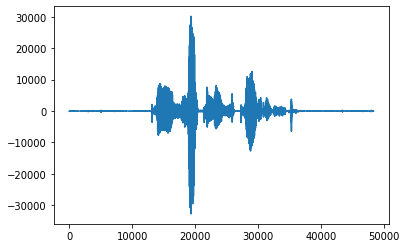

In [40]:
plt.plot(audio)

## Run VAD

In [41]:
raw_samples = struct.pack("%dh" % len(audio), *audio)

In [42]:
window_duration = 0.03 # duration in seconds
samples_per_window = int(window_duration * samplerate)
number_windows = int(np.floor(len(audio)/samples_per_window))
print(number_windows)
bytes_per_sample = 2

100


In [43]:
segments = []
for i in np.arange(number_windows):

    #stop = min(start + samples_per_window, len(audio) - samples_per_window)
    raw_frame = raw_samples[i * bytes_per_sample * samples_per_window: (i+1) * bytes_per_sample * samples_per_window]
    is_speech = vad.is_speech(raw_frame, 
                              sample_rate = samplerate)

    segments.append(dict(
       start = i * samples_per_window,
       stop = (i+1) * samples_per_window,
       is_speech = is_speech))
    

In [46]:
samples_per_window

480

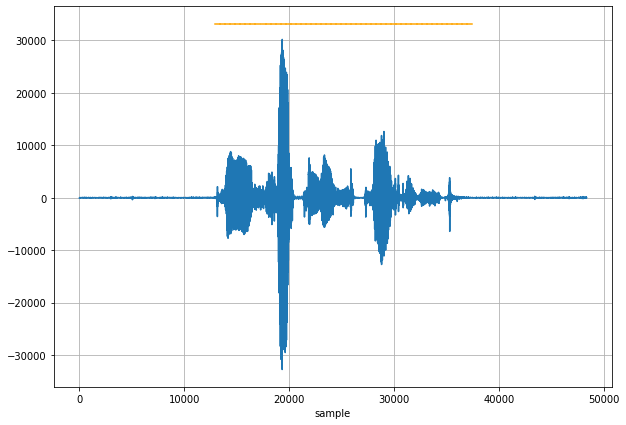

In [44]:
plt.figure(figsize = (10,7))
plt.plot(audio)

ymax = max(audio)

# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')

plt.xlabel('sample')
plt.grid()


In [35]:
ipd.Audio(audio, rate=samplerate)
